# Introduction

The procedure to build a VAR model involves the following steps:

1. Analyze the time series characteristics
<br>
2. Test for causation amongst the time series
<br>
3. Test for stationarity
<br>
4. Transform the series to make it stationary, if needed
<br>
5. Find optimal order (p)
<br>
6. Prepare training and test datasets
<br>
7. Train the model
<br>
8. Roll back the transformations
<br>
9. Evaluate the model using test set
<br>
10. Forecast to future

# Import packages

Import packages such as pandas, numpy, matplotlib, scipy and statsmodels

In [98]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import pearsonr
from dateutil.relativedelta import relativedelta

# Data importing, cleaning and preprocessing

Monthly data for the period January 2008 to January 2022 were sourced from Bloomberg and saved in an excel spreadsheet, with one dependent and eleven independent variables. (169)
<br>

The following data were collected:
<br>

- iShares J.P. Morgan USD Emerging Markets Bond ETF
- DAX Index
- VIX Index
- US 10-year government bond yield
- Euro / U.S. Dollar 
- Bloomberg US Corporate High-Yield Average OAS
- 2-year 10-year yield spread
- Euro Stoxx 50
- S&P 500 Indes
- Gold
- US 10-year breakeven rate
- U.S. Dollar Index

Logarithmic returns were calculated for the iShares J.P. Morgan USD Emerging Markets Bond ETF time-series and some data cleaning and preprocessing has been done.

In [58]:
df = pd.read_excel("Data.xlsx", sheet_name="Monthly_Python_Input", index_col=0)
#df = df.drop(columns=["EMB_US_Equity"])
df["EMB_US_Equity_log"] = np.log(df.EMB_US_Equity) - np.log(df.EMB_US_Equity.shift(1))
df = df.drop(columns=["EMB_US_Equity"]).dropna()
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
display(df.head())
display(df.tail())
print(df.shape) # (168, 12)

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2008-02-29,-0.008737,6748.13,26.54,3.5092,1.5179,7.45,189.578,3724.50,1330.63,973.90,2.4398,73.714
2008-03-31,-0.003259,6534.97,25.61,3.4096,1.5788,7.81,182.115,3628.06,1322.70,916.90,2.3246,71.802
2008-04-30,0.006999,6948.82,20.79,3.7279,1.5622,6.53,146.961,3825.02,1385.59,877.55,2.2798,72.509
2008-05-30,-0.003345,7096.79,17.83,4.0595,1.5554,6.22,145.713,3777.85,1400.38,886.50,2.5250,72.879
2008-06-30,-0.024545,6418.32,23.95,3.9690,1.5755,7.08,135.257,3352.81,1280.00,925.40,2.5430,72.463


,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2021-09-30,-0.029808,15260.69,23.14,1.4873,1.1580,2.89,120.787,4048.08,4307.54,1756.95,2.3762,94.230
2021-10-29,-0.001546,15688.77,16.26,1.5521,1.1558,2.87,105.118,4250.56,4605.38,1783.38,2.5870,94.123
2021-11-30,-0.022268,15100.13,27.19,1.4443,1.1338,3.37,87.338,4063.06,4567.00,1774.52,2.5131,95.994
2021-12-31,0.014686,15884.86,17.22,1.5101,1.1370,2.83,77.396,4298.41,4766.18,1829.20,2.5947,95.670
2022-01-31,-0.034325,15471.20,24.83,1.7767,1.1235,3.42,59.603,4174.60,4515.55,1797.17,2.4864,96.540


(168, 12)


# 1. Analyze the time series characteristics

Descriptive statistics

In [54]:
display(df.describe())

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,0.000176,9646.913214,20.374226,2.328403,1.247545,5.455060,140.953696,3117.319405,2115.345476,1355.810357,1.952763,87.900018
std,0.034245,3068.766621,8.990890,0.796853,0.130282,2.611803,78.091019,490.938235,946.142135,280.165019,0.408435,8.564552
min,-0.220326,3843.740000,9.510000,0.528200,1.051700,2.680000,-1.391000,1976.230000,735.090000,723.850000,0.088900,71.802000
25%,-0.010442,6835.125000,14.022500,1.765875,1.127925,3.710000,78.947250,2763.087500,1325.047500,1184.370000,1.735400,80.083750
50%,0.002441,9819.310000,17.745000,2.318650,1.223250,4.770000,140.939500,3130.970000,1999.180000,1300.655000,2.001050,89.883000
75%,0.014490,12203.462500,24.160000,2.860175,1.345600,6.270000,203.000500,3468.560000,2712.262500,1581.130000,2.243000,95.840750
max,0.152693,15884.860000,59.890000,4.059500,1.578800,18.330000,280.778000,4298.410000,4766.180000,1975.860000,2.594700,102.210000


Correlation matrix

In [55]:
display(df.corr())

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
EMB_US_Equity_log,1.000000,-0.023729,-0.253198,-0.102464,0.068512,-0.001733,-0.015768,-0.026599,-0.030058,0.055477,-0.050786,-0.067519
Dax_Index,-0.023729,1.000000,-0.425564,-0.546360,-0.705115,-0.702438,-0.705767,0.846289,0.949572,0.436941,0.079627,0.752968
VIX_Index,-0.253198,-0.425564,1.000000,0.048849,0.194393,0.779575,0.174452,-0.410337,-0.242238,-0.115388,-0.499724,-0.168314
USGG10YR_Index,-0.102464,-0.546360,0.048849,1.000000,0.615461,0.284694,0.551021,-0.175679,-0.594029,-0.747648,0.209428,-0.529718
EURUSD_BGN_Curncy,0.068512,-0.705115,0.194393,0.615461,1.000000,0.332001,0.715192,-0.387366,-0.619927,-0.237538,0.377126,-0.968212
LF98OAS_Index,-0.001733,-0.702438,0.779575,0.284694,0.332001,1.000000,0.341067,-0.611752,-0.600283,-0.470263,-0.586813,-0.307322
USYC2Y10_Index,-0.015768,-0.705767,0.174452,0.551021,0.715192,0.341067,1.000000,-0.482651,-0.687366,-0.291023,0.261540,-0.765381
SX5E_Index,-0.026599,0.846289,-0.410337,-0.175679,-0.387366,-0.611752,-0.482651,1.000000,0.794582,0.130235,0.214144,0.504423
SPX_Index,-0.030058,0.949572,-0.242238,-0.594029,-0.619927,-0.600283,-0.687366,0.794582,1.000000,0.553078,0.091118,0.670736
XAU BGN Curncy,0.055477,0.436941,-0.115388,-0.747648,-0.237538,-0.470263,-0.291023,0.130235,0.553078,1.000000,0.316722,0.122545


Visualization

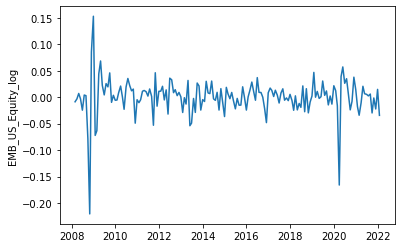

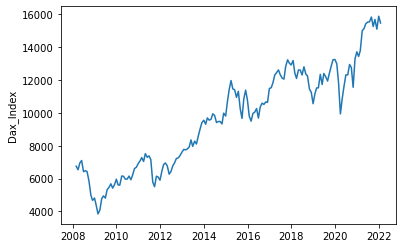

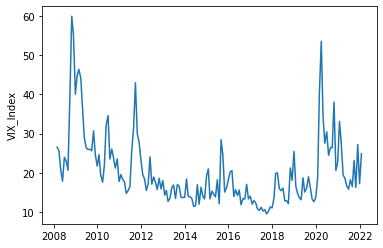

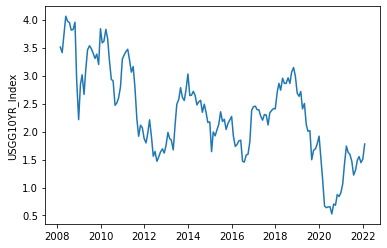

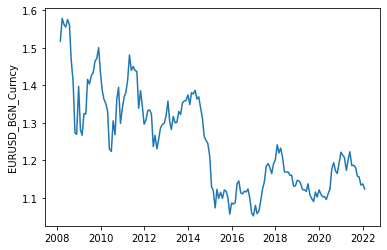

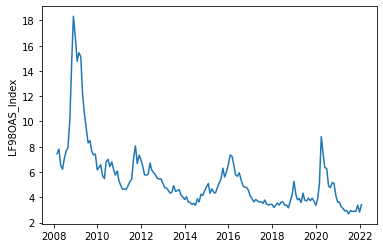

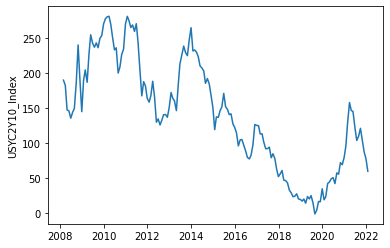

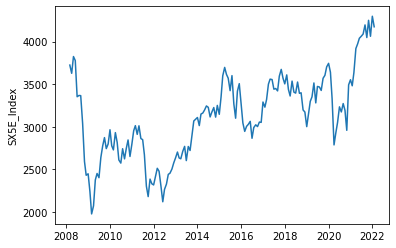

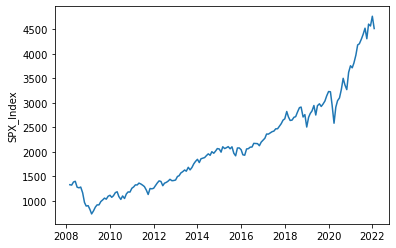

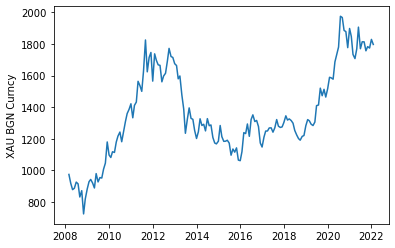

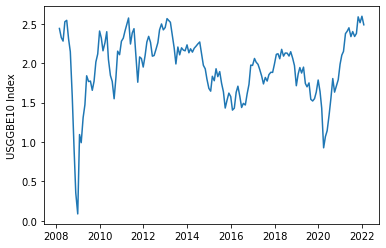

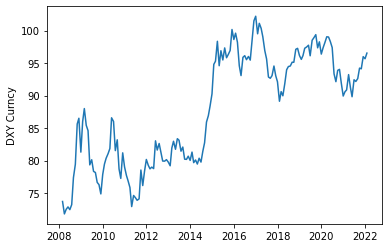

In [72]:
col = df.columns
for x in col:
    plt.plot(df[[x]])
    plt.ylabel(x)
    plt.show()

# 3. Test for stationarity

The VAR model requires the time series to be stationary (i.e. mean and variance do not change over time). Therefore, we need to check all the time series in the system for stationarity using unit-root tests. The two most commonly used are the Augmented Dickey-Fuller test (ADF test) and Philip-Perron test.

The Dickey–Fuller test tests the null hypothesis that a unit root is present in the time series model. If the null hypothesis can be rejected, the time series is stationary.

The output from the code below can be summarized as follows:

Stationary time series:

* EMB US Equity
* VIX Index
* USGGBE10 Index

Non-stationary time series:

* Dax Index
* USGG10YR Index
* EURUSD Index
* LF98OAS Index
* USYC2Y10 Index
* SX5E Index
* SPX Index
* XAU BGN Curncy
* DXY Curncy


In [59]:
# split data into training and testing
nobs = 4
df_train, df_test = df[:-nobs], df[-nobs:]

# check size
print(df_train.shape) # (164, 12)
print(df_test.shape) # (4, 12)


def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

(164, 12)
(4, 12)
    Augmented Dickey-Fuller Test on "EMB_US_Equity_log" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1746
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Dax_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.3742
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.9143. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "VIX_Index" 
    -----------------------------------------------
 Null Hypothesis:

In order to make the non-stationary time series stationary, we need to take first differences and re-run the ADF test. The output below summarizes the results, showing that all time series are now stationary after differencing.

    Augmented Dickey-Fuller Test on "EMB_US_Equity_log" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8619
 No. Lags Chosen       = 4
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Dax_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.068
 No. Lags Chosen       = 1
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VIX_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

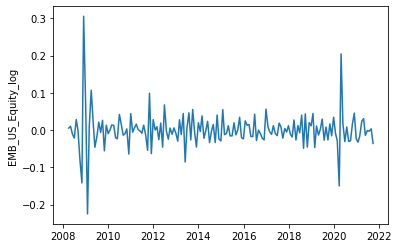

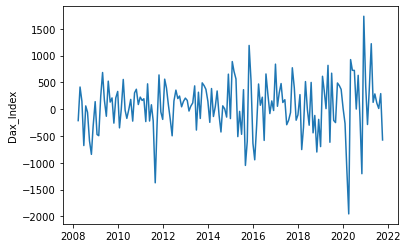

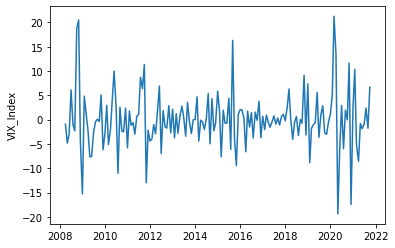

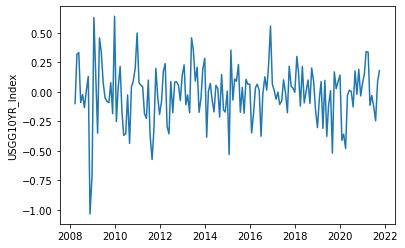

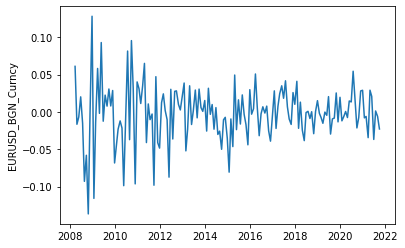

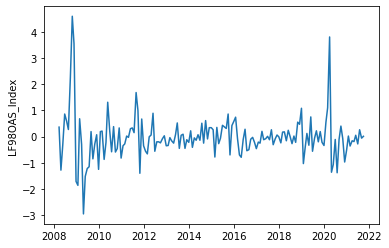

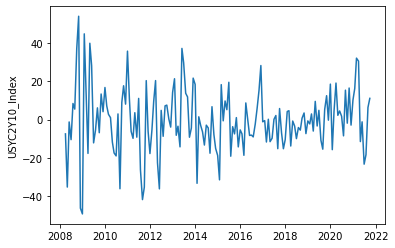

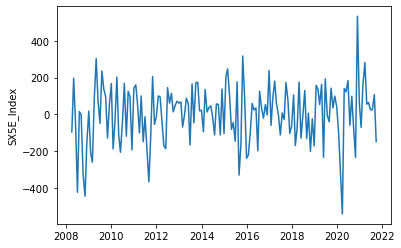

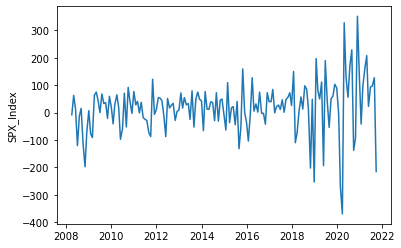

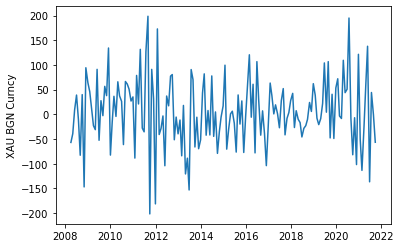

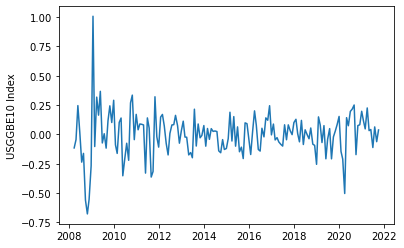

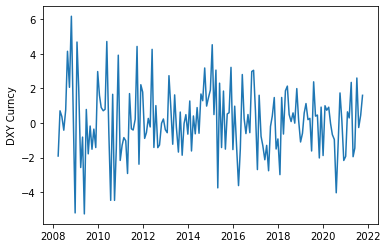

In [75]:
# 1st difference
df_differenced = df_train.diff().dropna()

# # Re-run ADF Test on each column after Differencing
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

# plot data to investigate vizualy
col = df.columns
for x in col:
    plt.plot(df_differenced[[x]])
    plt.ylabel(x)
    plt.show()

# 4. Find optimal order (p)

The lag length p is unknown and therefore has to be estimated via various lag length selection criteria such as the Aikaike’s information criterion (AIC) (Akaike 1973), Bayesian information criterion (BIC) (Akaike 1979), final prediction error (FPE) (Akaike 1969) and Hannan-Quinn criterion (HQC) (Hannan and Quinn 1979). Following the usual practice of looking at the AIC, we select lag order = 2 as it provides the lowest AIC value of 19.2347.

In [66]:
model = VAR(df_differenced)
for i in [0,1,2,3,4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  20.5645927037248
BIC :  20.79235345470444
FPE :  853276796.9689449
HQIC:  20.657061072426036 

Lag Order = 1
AIC :  19.315736992218877
BIC :  22.28897790762784
FPE :  245765179.22687075
HQIC:  20.52291792872279 

Lag Order = 2
AIC :  19.234738703145283
BIC :  24.976485967091488
FPE :  232670089.74861616
HQIC:  21.566121336133893 

Lag Order = 3
AIC :  19.339003740636265
BIC :  27.872611077910133
FPE :  277473563.798888
HQIC:  22.804206034385523 

Lag Order = 4
AIC :  19.577792724546143
BIC :  30.92694788747379
FPE :  407788361.6576575
HQIC:  24.186563798865382 



C:\Users\t.burggraf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


# 6. Prepare training and test datasets

xxxx

In [67]:
# split data into training and testing
nobs = 4
df_train, df_test = df[:-nobs], df[-nobs:]

# check size
print(df_train.shape) # (164, 12)
print(df_test.shape) # (4, 12)

(164, 12)
(4, 12)


# 7. Train the model

xxxxx

In [70]:
model_fitted = model.fit(2)
display(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Feb, 2022
Time:                     08:43:45
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    24.9765
Nobs:                     161.000    HQIC:                   21.5661
Log likelihood:          -3989.79    FPE:                2.32670e+08
AIC:                      19.2347    Det(Omega_mle):     4.11619e+07
--------------------------------------------------------------------
Results for equation EMB_US_Equity_log
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.002377         0.003345            0.711           0.477
L1.EMB_US_Equity_log        -0.416593         0.135950           -3.064           0.002
L1.Dax_Index        

# 8. Check for serial correlation

xxxx

In [76]:
# Check for serial correlation


# def adjust(val, length= 6): return str(val).ljust(length)
# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

# def cointegration_test(df, alpha=0.05):
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df,-1,5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)
#
#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
#
# cointegration_test(df)
#
# from statsmodels.stats.stattools import durbin_watson
# out = durbin_watson(model_fitted.resid)
#
#
#
#  # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
#
# print(cointegration_test(df))

# Forecast VAR model (backtest)

xxxx

2


'Forecast'

,EMB_US_Equity_log_forecast,Dax_Index_forecast,VIX_Index_forecast,USGG10YR_Index_forecast,EURUSD_BGN_Curncy_forecast,LF98OAS_Index_forecast,USYC2Y10_Index_forecast,SX5E_Index_forecast,SPX_Index_forecast,XAU BGN Curncy_forecast,USGGBE10 Index_forecast,DXY Curncy_forecast
Date,,,,,,,,,,,,
2021-10-29,-0.010473,15163.748153,21.394093,1.451182,1.172120,2.868728,126.608558,4004.014755,4314.908418,1792.179931,2.445547,93.639837
2021-11-30,0.004107,15478.866039,16.758491,1.464582,1.171364,2.600413,126.097693,4076.877955,4388.718451,1800.718470,2.436235,93.723955
2021-12-31,-0.003675,15642.063460,16.671775,1.505909,1.162496,2.215692,126.503602,4107.532008,4416.414358,1792.513192,2.499940,93.977280
2022-01-31,-0.012723,15667.572056,17.583973,1.510377,1.160854,2.214035,128.125228,4102.965707,4430.219210,1805.737611,2.514180,94.043150


'Actual'

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2021-10-29,-0.001546,15688.77,16.26,1.5521,1.1558,2.87,105.118,4250.56,4605.38,1783.38,2.5870,94.123
2021-11-30,-0.022268,15100.13,27.19,1.4443,1.1338,3.37,87.338,4063.06,4567.00,1774.52,2.5131,95.994
2021-12-31,0.014686,15884.86,17.22,1.5101,1.1370,2.83,77.396,4298.41,4766.18,1829.20,2.5947,95.670
2022-01-31,-0.034325,15471.20,24.83,1.7767,1.1235,3.42,59.603,4174.60,4515.55,1797.17,2.4864,96.540


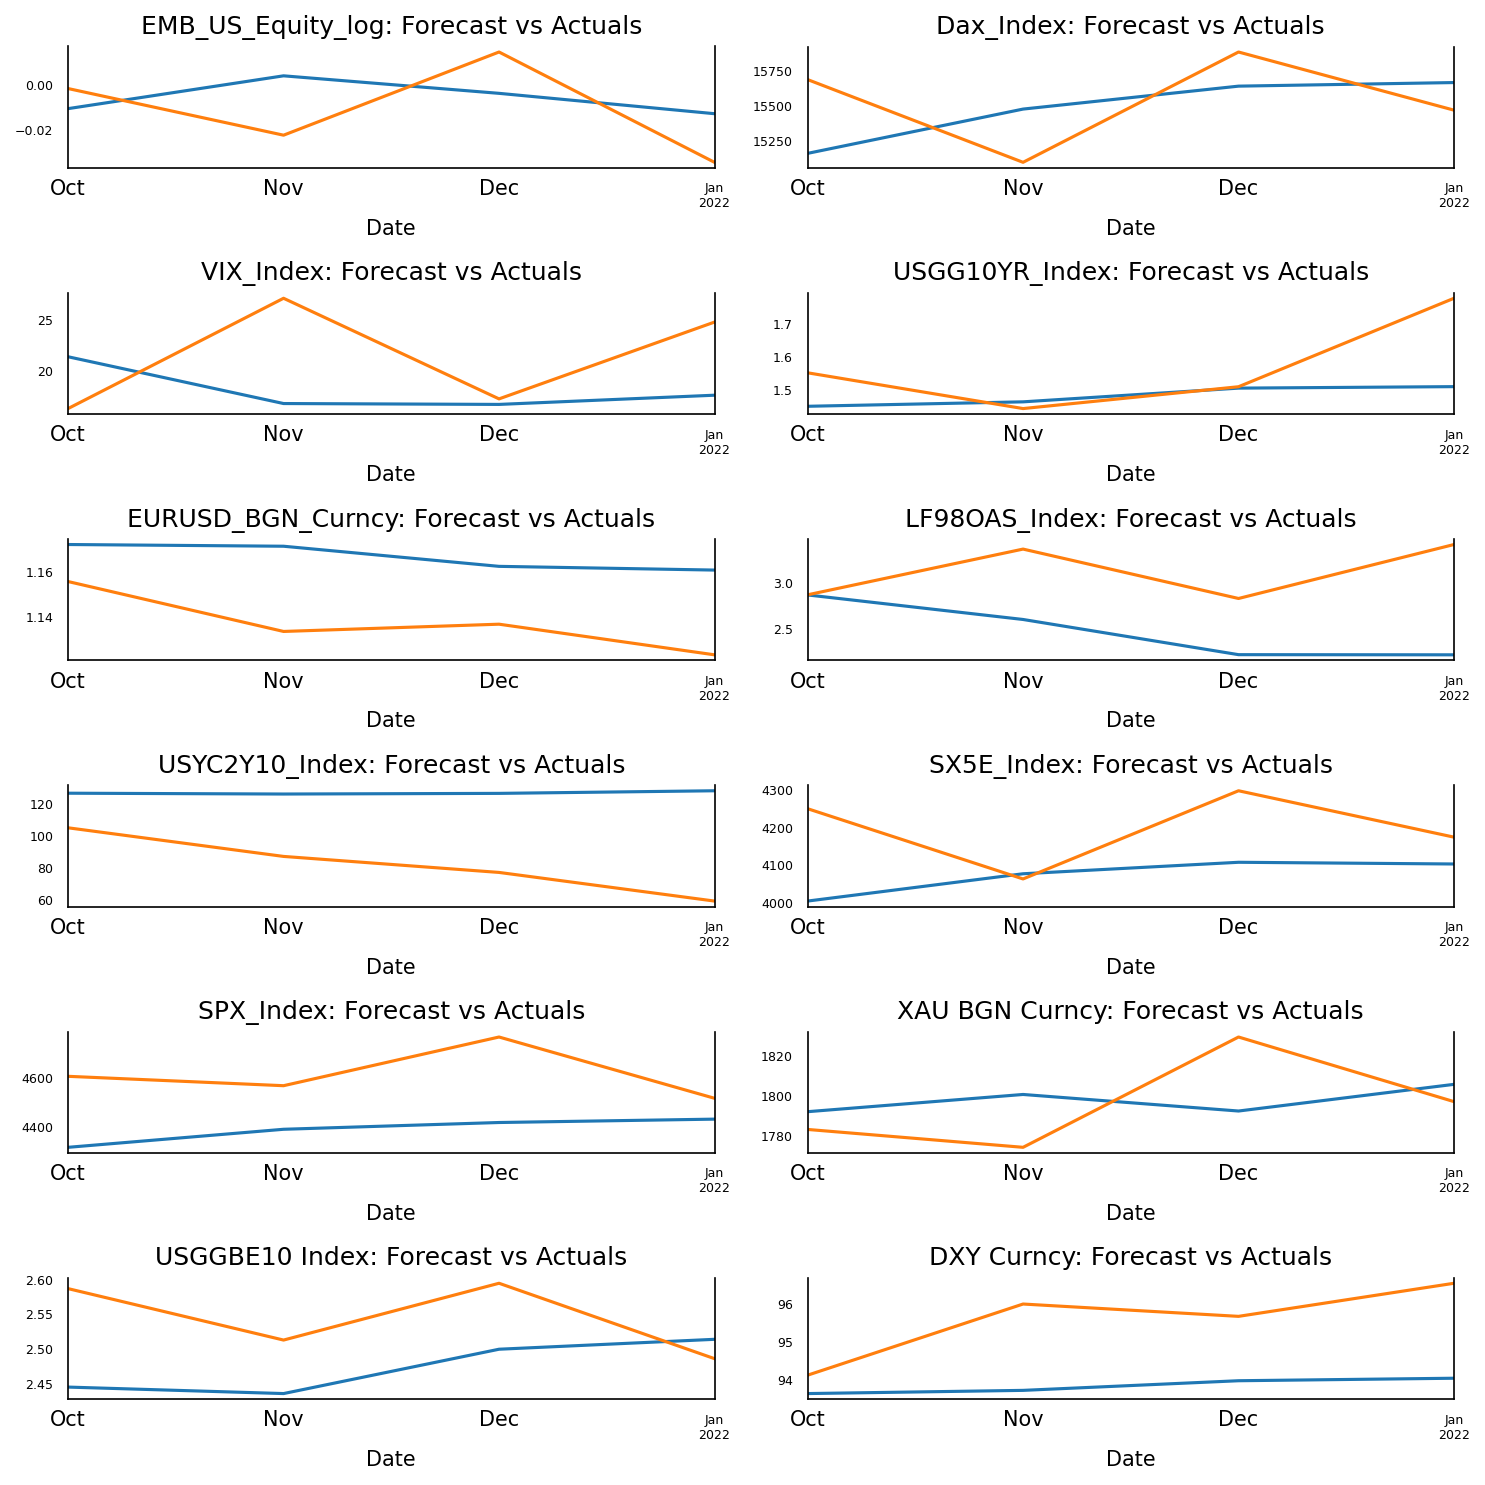

In [95]:
# Forecast with the VAR model
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

fc = model_fitted.forecast(y=forecast_input, steps=nobs) # hier auch 7 steps eingeben!
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')

# Reverse differencing
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=False)

df_results = df_results.loc[:, ['EMB_US_Equity_log_forecast', 'Dax_Index_forecast', 'VIX_Index_forecast', 'USGG10YR_Index_forecast',
                   'EURUSD_BGN_Curncy_forecast', 'LF98OAS_Index_forecast', 'USYC2Y10_Index_forecast', 'SX5E_Index_forecast',
                   'SPX_Index_forecast', 'XAU BGN Curncy_forecast', 'USGGBE10 Index_forecast', 'DXY Curncy_forecast']]

display("Forecast", df_results)
display("Actual", df[-4:])

# Plot of forecasts vs actuals
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=False, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=False, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
plt.show()

# Forecast VAR model (Feb. - May 2022)

xxxx

In [109]:
df_differenced = df.diff().dropna()
model = VAR(df_differenced)

# Train the VAR model
lag_order = 2
model_fitted = model.fit(lag_order)

# forecasting
forecast_input = df_differenced.values[-lag_order:]

ind = df.index
ind = ind.tolist()

list = [1,2,3,4]
for x in list:
    future_date = ind[-1] + relativedelta(months=1)
    ind.append(future_date)

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc,index=ind[-nobs:], columns=df.columns + '_1d')

# Reverse invert
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=False)

df_results = df_results.loc[:, ['EMB_US_Equity_log_forecast', 'Dax_Index_forecast', 'VIX_Index_forecast', 'USGG10YR_Index_forecast',
                   'EURUSD_BGN_Curncy_forecast', 'LF98OAS_Index_forecast', 'USYC2Y10_Index_forecast', 'SX5E_Index_forecast',
                   'SPX_Index_forecast', 'XAU BGN Curncy_forecast', 'USGGBE10 Index_forecast', 'DXY Curncy_forecast']]

display("Forecast",df_results)
display("Actual", df[-4:])

C:\Users\t.burggraf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


'Forecast'

,EMB_US_Equity_log_forecast,Dax_Index_forecast,VIX_Index_forecast,USGG10YR_Index_forecast,EURUSD_BGN_Curncy_forecast,LF98OAS_Index_forecast,USYC2Y10_Index_forecast,SX5E_Index_forecast,SPX_Index_forecast,XAU BGN Curncy_forecast,USGGBE10 Index_forecast,DXY Curncy_forecast
2022-02-28,0.010219,15098.213944,19.846449,1.337103,1.178210,2.713592,100.649056,3994.695762,4341.627492,1754.309011,2.474377,93.162971
2022-03-28,0.008973,15162.781571,17.620856,1.342084,1.179446,2.675408,94.020122,3998.706596,4381.490828,1797.759872,2.475961,93.209233
2022-04-28,-0.011407,15075.377344,18.788095,1.418351,1.161527,2.543656,93.326331,3946.791187,4374.330938,1766.485912,2.507911,93.976764
2022-05-28,-0.001139,15147.273249,18.361147,1.413756,1.155742,2.626341,93.066909,3955.139718,4395.827431,1779.382589,2.532545,94.231415


'Actual'

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
Date,,,,,,,,,,,,
2021-10-29,-0.001546,15688.77,16.26,1.5521,1.1558,2.87,105.118,4250.56,4605.38,1783.38,2.5870,94.123
2021-11-30,-0.022268,15100.13,27.19,1.4443,1.1338,3.37,87.338,4063.06,4567.00,1774.52,2.5131,95.994
2021-12-31,0.014686,15884.86,17.22,1.5101,1.1370,2.83,77.396,4298.41,4766.18,1829.20,2.5947,95.670
2022-01-31,-0.034325,15471.20,24.83,1.7767,1.1235,3.42,59.603,4174.60,4515.55,1797.17,2.4864,96.540
